## Bayesian hierarchical model to estimate treatment effects

Here, I attempt to account for the simultaneous impact of sensor feedback on lift rates and safety by:

Model 1: y = a + b1Treatment + b2LiftRate-t + error
b1 = p + qLiftRate-t + error


Model 2: y = a + b1Treatment + b2estimate(LiftRate-t) + error
b1 = p + qLiftRate-t + error
estimated(LiftRate-t) = m + nLiftRate-t-1

Model 3: 
y = a + b1Treatment + b2LiftRate-t + error
b2 = p + qTreatment + mLift-Rate-t-1 error



In [114]:
import pymc as pm
import pandas as pd
import itertools as itt
import arviz as az
import graphviz
import numpy as np
import importlib as imp
import matplotlib.pyplot as plt

In [31]:
full_obs = df.copy().dropna()
full_obs['change LF'] = full_obs['Intervention Average Lift Rate'] - full_obs['Baseline Average Lift Rate']

#lift rates
int_lift_rates = full_obs['Intervention Average Lift Rate'].values.reshape(-1, 1)
base_lift_rates = full_obs['Baseline Average Lift Rate'].values.reshape(-1, 1)

#scores
int_scores = full_obs['Intervention Average Safety Score'].values.reshape(-1, 1)
base_scores = full_obs['Baseline Average Safety Score'].values.reshape(-1, 1)

#treatments
int_treatments = pd.get_dummies(full_obs['Haptic Group'])
tr_names = int_treatments.columns
treatments = int_treatments.values
tr_names

no_obs = full_obs.shape[0]

In [136]:
melted_df = pd.read_csv("melted_data.csv")
df = pd.read_csv("data.csv")

## Model 1

Simple setup - to test only treatment itself, not its variations at first.

Ref: https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/


$$ S_{int}^i \sim N(\mu_S, \sigma_S)$$

$$\mu_S^i = a^i + b_1^iT + cLR^i$$

Group intercept + individual effects

$$ \alpha \sim N(0, 1000) $$

$$ a_f^i \sim N(0, 1) $$

$$ \sigma_a = HC(5) $$

$$ a_i = \alpha + a_f^i * \sigma_{\alpha} $$


Lift-rate impact

$$ c \sim N(0, 1000) $$


Treatment effect

$$ \beta \sim N(0, 1000) $$

$$ f_b^i \sim N(0, 1) $$

$$ \sigma_{\beta} = HC(5) $$

$$ b_i = \beta + f_b^i * \sigma_{\beta} + qLR^i $$

$$ q \sim N(0, 1000) $$




In [213]:
melted_df['Treatment'] = 1*(melted_df['Stage'] == 'Intervention')

melted_full_obs = melted_df.dropna().copy()

Stage                      Participation           Haptic Group  \
0        Baseline      Participated in baseline only  2 bends in 10 minutes   
1        Baseline      Participated in baseline only  2 bends in 10 minutes   
2        Baseline      Participated in baseline only  2 bends in 10 minutes   
3        Baseline      Participated in baseline only  2 bends in 10 minutes   
4        Baseline      Participated in baseline only  2 bends in 10 minutes   
..            ...                                ...                    ...   
529  Intervention  Participated in intervention only   3 bends in 8 minutes   
530  Intervention  Participated in intervention only   3 bends in 8 minutes   
531  Intervention  Participated in intervention only   3 bends in 8 minutes   
532  Intervention  Participated in intervention only   3 bends in 8 minutes   
533  Intervention  Participated in intervention only   3 bends in 8 minutes   

               ID  Average Lift Rate  Average Max Forward Bend  \
0    A8R948411614              117.5                      95.3   
1    A8R948412873               89.3                      87.6   
2    A8R948413368              103.9                      77.0   
3    A8R948423022              111.5                      82.1   
4    A8R948454341               90.9                      83.9   
..            ...                ...                       ...   
529  A8R905214772               89.5                      79.9   
530  A8R948468908               54.3                      50.5   
531  A8R952527381               57.0                      77.7   
532  A8R963604009               82.4                      80.0   
533  A8R971418592              107.2                      77.9   

     Average Max Tilt Velocity  Average Safety Score  Average Twist Velocity  \
0                         71.9                  68.1                    19.3   
1                        105.9                  57.9                    22.3   
2                         87.8                  64.5                    23.9   
3                         66.0                  71.1                    20.6   
4                         80.0                  69.9                    16.4   
..                         ...                   ...                     ...   
529                       95.9                  64.7                    18.6   
530                       68.7                  75.6                    25.0   
531                       84.1                  70.6                    17.5   
532                       74.9                  69.6                    22.1   
533                       70.3                  71.3                    20.3   

     File Count             Treatment  
0          19.0              Baseline  
1           2.0              Baseline  
2           3.0              Baseline  
3           9.0              Baseline  
4          17.0              Baseline  
..          ...                   ...  
529         7.0  3 bends in 8 minutes  
530        10.0  3 bends in 8 minutes  
531         1.0  3 bends in 8 minutes  
532         1.0  3 bends in 8 minutes  
533        19.0  3 bends in 8 minutes  

[534 rows x 11 columns]

In [137]:
melted_df['Treatment'] = 1*(melted_df['Stage'] == 'Intervention')

melted_full_obs = melted_df.dropna().copy()

## Model 1 - baseline, simple regression linking treatment and lift rate

In [105]:
with pm.Model() as base_model:
    
    #register the data
    scores = pm.Data("scores", melted_full_obs['Average Safety Score'].values.reshape(-1, 1), mutable=True)    
    rates = pm.Data("lift_rates", melted_full_obs['Average Lift Rate'].values.reshape(-1, 1), mutable=True)    
    treatments = pm.Data("treatment", melted_full_obs['Treatment'].values.reshape(-1, 1), mutable=True) 
    
    ##Setting intercept
    a = pm.Normal("alpha", 0, 1000)
    
    #Treatment effect
    b = pm.Normal("beta", 0, 100)
    
    ##Lift rate direct effect
    c = pm.Normal("gamma", 0, 100)
    
    ## Model errors
    sigma_S = pm.HalfCauchy("sigma_S", 3)    
    mu = a + b * treatments + c * rates
    pm.Normal("s", mu, sigma_S, observed=scores)

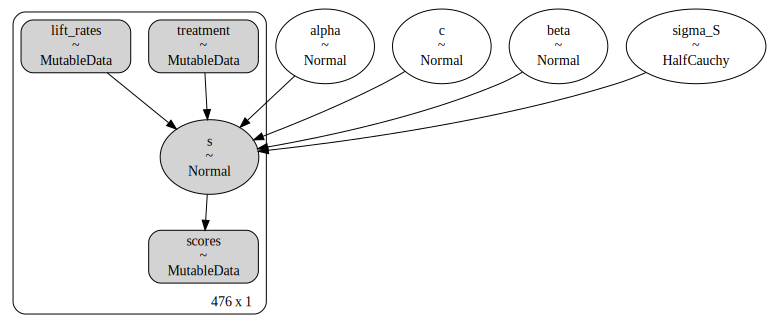

In [106]:
pm.model_to_graphviz(base_model)

In [108]:
with base_model:
    base_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/aurimas/apps/anaconda3/envs/strongarm/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, c, sigma_S]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The acceptance probability does not match the target. It is 0.8842, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9071, but should be close to 0.8. Try to increase the number of tuning steps.


In [110]:
results = az.summary(base_trace, hdi_prob=0.90, var_names=['alpha', 'beta', 'gamma', 'sigma_S'])
results

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
alpha    78.569  0.927  77.028   80.081      0.023    0.016    1702.0   
beta      0.381  0.442  -0.314    1.145      0.009    0.007    2643.0   
c        -0.110  0.009  -0.123   -0.095      0.000    0.000    1666.0   
sigma_S   4.754  0.158   4.515    5.030      0.003    0.002    3008.0   

         ess_tail  r_hat  
alpha      1955.0    1.0  
beta       2169.0    1.0  
c          1991.0    1.0  
sigma_S    2105.0    1.0

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'sigma_S'}>,
        <AxesSubplot:title={'center':'sigma_S'}>]], dtype=object)

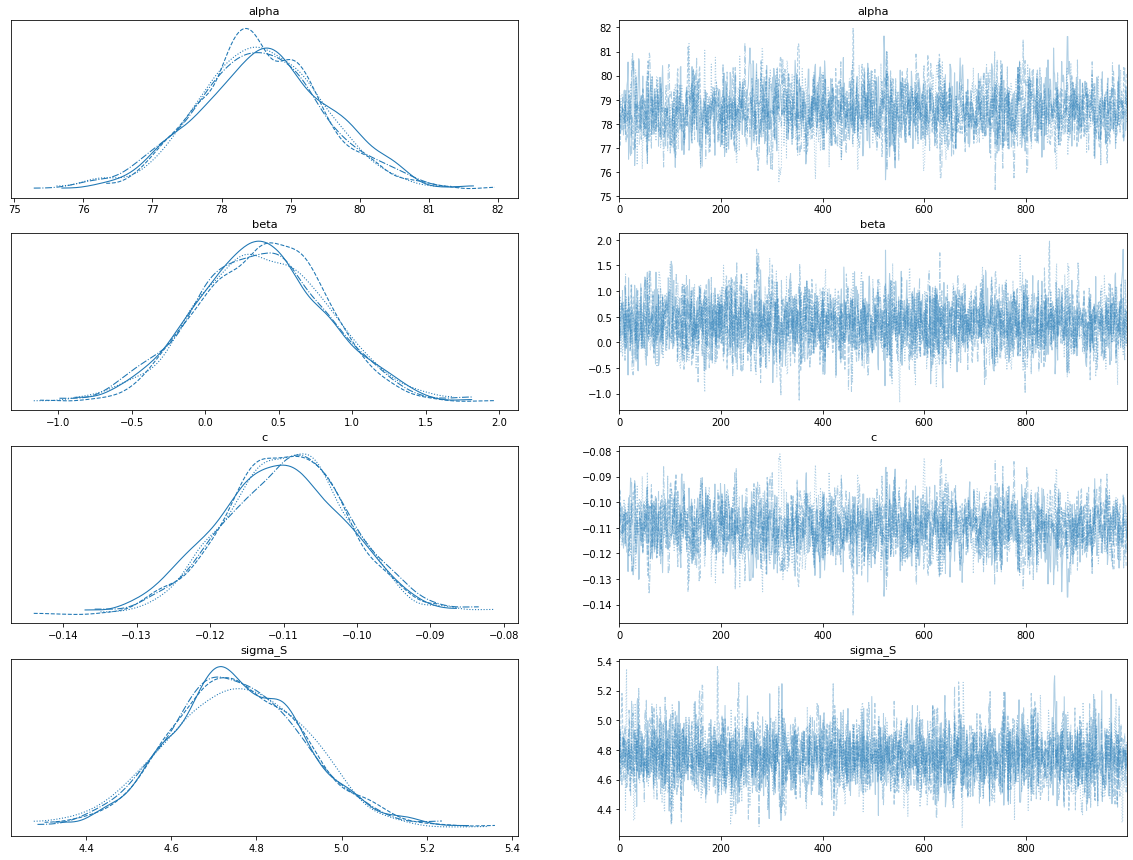

In [160]:
az.plot_trace(base_trace, figsize=(20,15))

## Model 2 - add individual random effects

In [148]:
melted_full_obs['idx'] = pd.Categorical(melted_full_obs['ID']).codes

In [156]:
coords = {
    "worker": melted_full_obs['idx'].unique(),
    "obs_id": np.arange(melted_full_obs.shape[0])
}

with pm.Model(coords = coords) as random_effects_model:
    
    #register the data
    scores = pm.Data("scores", melted_full_obs['Average Safety Score'].values, mutable=True)    
    rates = pm.Data("lift_rates", melted_full_obs['Average Lift Rate'].values, mutable=True)    
    treatments = pm.Data("treatment", melted_full_obs['Treatment'].values, mutable=True) 
    idx = pm.Data("indx", melted_full_obs['idx'].values)
    
    ##Setting intercepts
    sigma_a = pm.HalfCauchy("sigma_a", 3)
    f_a = pm.Normal("fixed_a", 0, 1, dims="worker")
    α = pm.Normal("alpha", 0, 1000)
    a = pm.Deterministic("a", α + f_a[idx] * sigma_a, dims="obs_id")
       
    #Treatment effect
    b = pm.Normal("beta", 0, 100)
    
    ##Lift rate direct effect
    c = pm.Normal("gamma", 0, 100)
    
    ## Model errors
    sigma_S = pm.HalfCauchy("sigma_S", 3)    
    mu = pm.Deterministic("mu", a + b * treatments + c * rates, dims="obs_id")
    pm.Normal("s", mu, sigma_S, observed=scores, dims="obs_id")

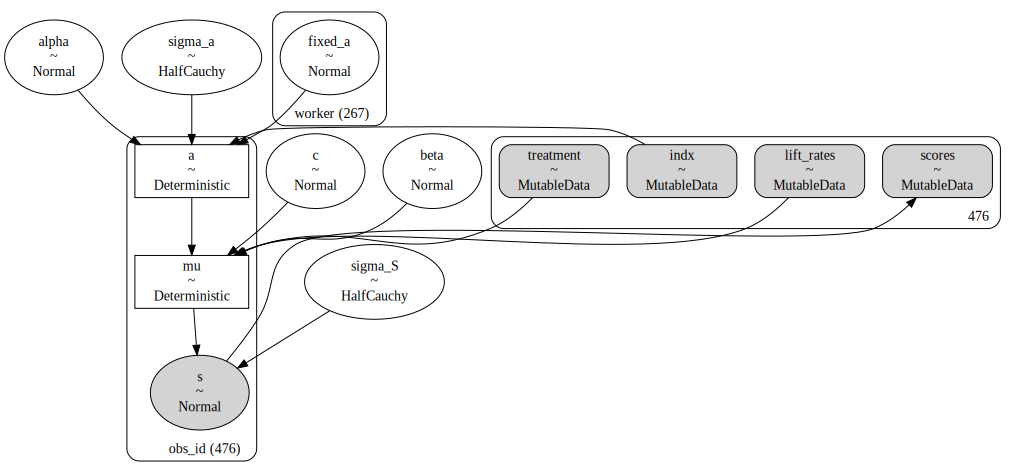

In [157]:
pm.model_to_graphviz(random_effects_model)

In [158]:
with random_effects_model:
    random_effects_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/aurimas/apps/anaconda3/envs/strongarm/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, fixed_a, alpha, beta, c, sigma_S]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7199, but should be close to 0.8. Try to increase the number of tuning steps.


In [165]:
az.summary(random_effects_trace, hdi_prob=0.90, var_names=['alpha', 'beta', 'gamma', 'sigma_S', 'sigma_a'])

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
alpha    78.785  0.902  77.251   80.256      0.023    0.017    1495.0   
beta      0.366  0.271  -0.088    0.794      0.004    0.003    3728.0   
c        -0.112  0.008  -0.125   -0.098      0.000    0.000    1195.0   
sigma_S   2.658  0.130   2.457    2.876      0.004    0.003     783.0   
sigma_a   3.979  0.219   3.605    4.319      0.007    0.005    1058.0   

         ess_tail  r_hat  
alpha      1051.0   1.00  
beta       1684.0   1.00  
c           996.0   1.01  
sigma_S     725.0   1.00  
sigma_a    1631.0   1.00

array([[<AxesSubplot:title={'center':'fixed_a'}>,
        <AxesSubplot:title={'center':'fixed_a'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'sigma_a'}>,
        <AxesSubplot:title={'center':'sigma_a'}>],
       [<AxesSubplot:title={'center':'sigma_S'}>,
        <AxesSubplot:title={'center':'sigma_S'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>]], dtype=object)

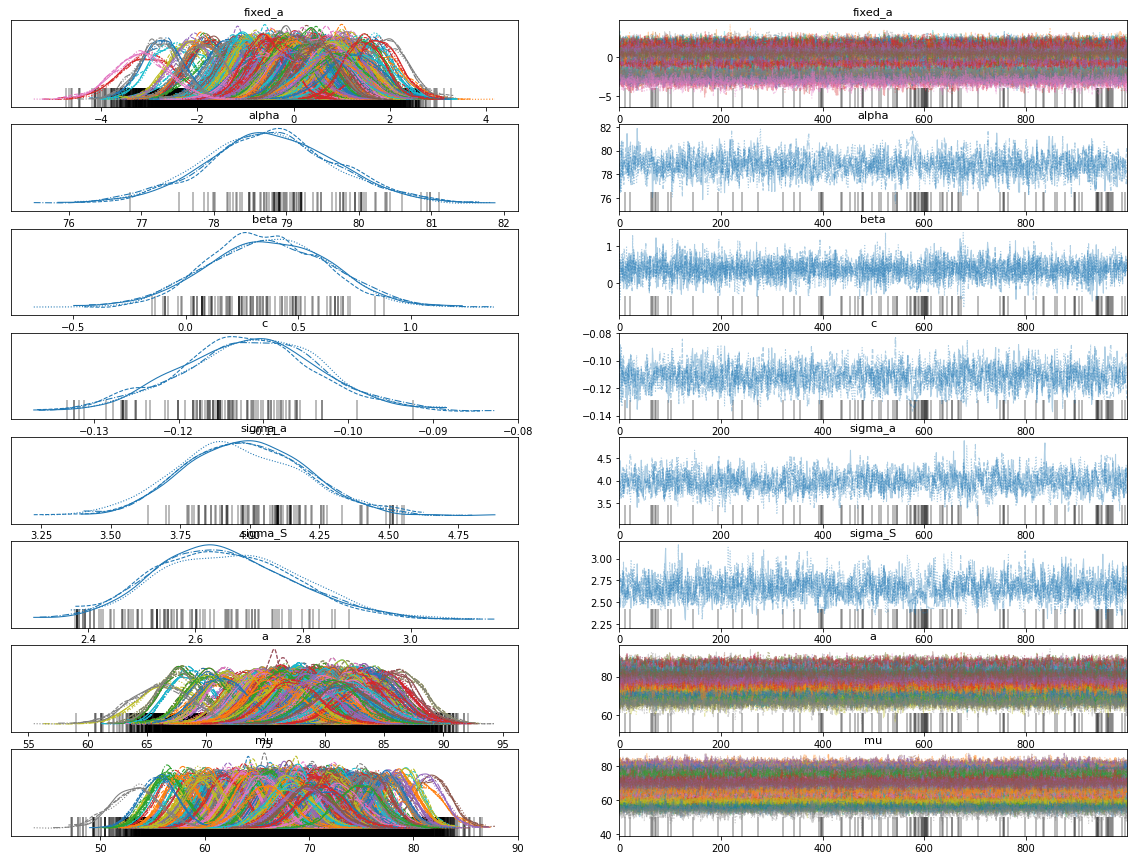

In [161]:
az.plot_trace(random_effects_trace, figsize=(20,15))

## Model 3 - adding random effects to the lift-rate relationship

In [185]:
coords = {
    "worker": melted_full_obs['idx'].unique(),
    "obs_id": np.arange(melted_full_obs.shape[0])
}

with pm.Model(coords = coords) as model3:
    
    #register the data
    scores = pm.Data("scores", melted_full_obs['Average Safety Score'].values, mutable=True)    
    rates = pm.Data("lift_rates", melted_full_obs['Average Lift Rate'].values, mutable=True)    
    treatments = pm.Data("treatment", melted_full_obs['Treatment'].values, mutable=True) 
    idx = pm.Data("indx", melted_full_obs['idx'].values, mutable=True)
    
    ##Setting intercepts
    sigma_a = pm.HalfCauchy("sigma_a", 3)
    f_a = pm.Normal("fixed_a", 0, 1, dims="worker")
    α = pm.Normal("alpha", 0, 1000)
    a = pm.Deterministic("a", α + f_a[idx] * sigma_a, dims="obs_id")
       
    #Treatment effect        
    b = pm.Normal("beta", 0, 1000)    
    
    ##Lift rate direct effect
    γ = pm.Normal("gamma", 0, 100)
    sigma_c = pm.HalfCauchy("sigma_c", 3)
    f_c = pm.Normal("fixed_c", 0, 1, dims="worker")    
    c = pm.Deterministic("c", γ + f_c[idx] * sigma_c, dims="obs_id")
    
    ## Model errors
    sigma_S = pm.HalfCauchy("sigma_S", 3)    
    mu = pm.Deterministic("mu", a + b * treatments + c * rates, dims="obs_id")
    pm.Normal("s", mu, sigma_S, observed=scores, dims="obs_id")

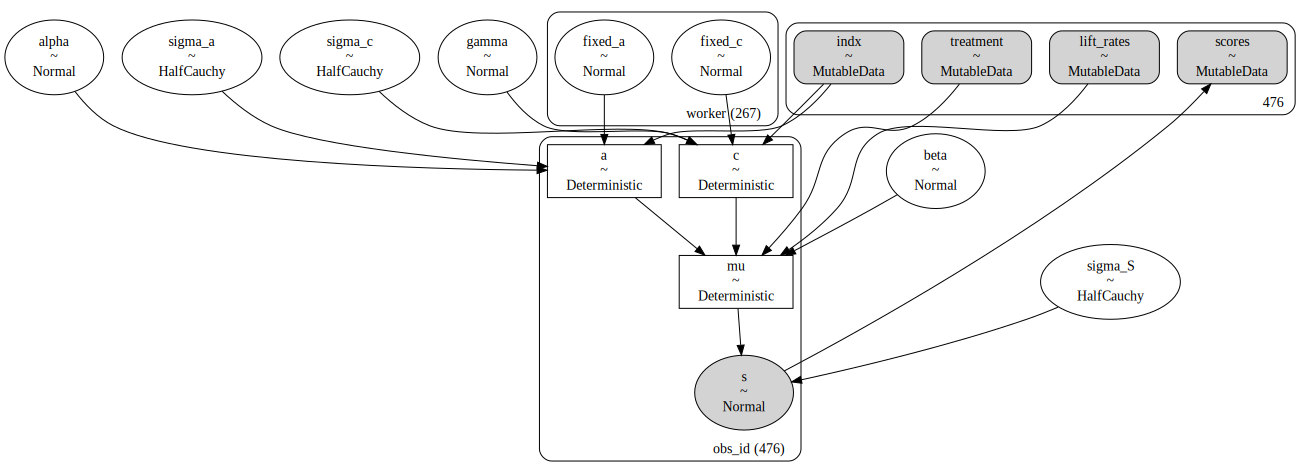

In [186]:
pm.model_to_graphviz(model3)

In [187]:
with model3:
    model3_trace = pm.sample(tune=2_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/aurimas/apps/anaconda3/envs/strongarm/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, fixed_a, alpha, beta, gamma, sigma_c, fixed_c, sigma_S]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 36 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [188]:
az.summary(model3_trace, hdi_prob=0.90, var_names=['alpha', 'beta', 'gamma', 'sigma_S', 'sigma_a', 'sigma_c'])

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
alpha    78.763  0.870  77.395   80.233      0.022    0.015    1585.0   
beta      0.368  0.268  -0.066    0.818      0.004    0.003    4208.0   
gamma    -0.111  0.008  -0.124   -0.097      0.000    0.000    1559.0   
sigma_S   2.653  0.133   2.438    2.864      0.004    0.003    1194.0   
sigma_a   3.961  0.240   3.577    4.366      0.010    0.007     566.0   
sigma_c   0.005  0.004   0.000    0.011      0.000    0.000     191.0   

         ess_tail  r_hat  
alpha      2256.0   1.01  
beta       2572.0   1.00  
gamma      1997.0   1.01  
sigma_S    2318.0   1.00  
sigma_a     840.0   1.01  
sigma_c     317.0   1.02

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'gamma'}>,
        <AxesSubplot:title={'center':'gamma'}>],
       [<AxesSubplot:title={'center':'sigma_S'}>,
        <AxesSubplot:title={'center':'sigma_S'}>],
       [<AxesSubplot:title={'center':'sigma_a'}>,
        <AxesSubplot:title={'center':'sigma_a'}>],
       [<AxesSubplot:title={'center':'sigma_c'}>,
        <AxesSubplot:title={'center':'sigma_c'}>]], dtype=object)

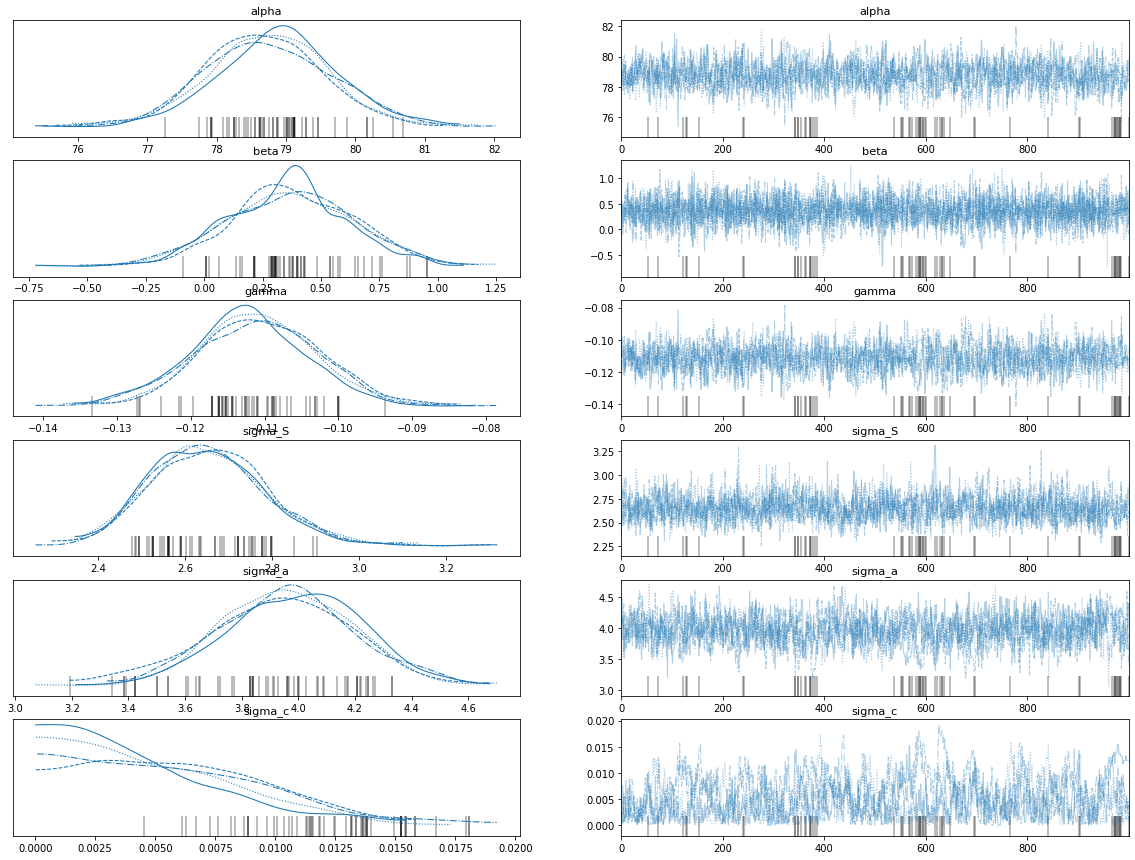

In [191]:
az.plot_trace(model3_trace, figsize=(20,15), var_names=['alpha', 'beta', 'gamma', 'sigma_S', 'sigma_a', 'sigma_c'])

## Model 4 - what about no random effects in the intercept instead?

In [192]:
coords = {
    "worker": melted_full_obs['idx'].unique(),
    "obs_id": np.arange(melted_full_obs.shape[0])
}

with pm.Model(coords = coords) as model4:
    
    #register the data
    scores = pm.Data("scores", melted_full_obs['Average Safety Score'].values, mutable=True)    
    rates = pm.Data("lift_rates", melted_full_obs['Average Lift Rate'].values, mutable=True)    
    treatments = pm.Data("treatment", melted_full_obs['Treatment'].values, mutable=True) 
    idx = pm.Data("indx", melted_full_obs['idx'].values, mutable=True)
    
    ##Setting intercepts    
    a = pm.Normal("alpha", 0, 1000)    
       
    #Treatment effect        
    b = pm.Normal("beta", 0, 1000)    
    
    ##Lift rate direct effect
    γ = pm.Normal("gamma", 0, 100)
    sigma_c = pm.HalfCauchy("sigma_c", 3)
    f_c = pm.Normal("fixed_c", 0, 1, dims="worker")    
    c = pm.Deterministic("c", γ + f_c[idx] * sigma_c, dims="obs_id")
    
    ## Model errors
    sigma_S = pm.HalfCauchy("sigma_S", 3)    
    mu = pm.Deterministic("mu", a + b * treatments + c * rates, dims="obs_id")
    pm.Normal("s", mu, sigma_S, observed=scores, dims="obs_id")

In [193]:
with model4:
    model4_trace = pm.sample(tune=2_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/aurimas/apps/anaconda3/envs/strongarm/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma, sigma_c, fixed_c, sigma_S]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 23 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7215, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [195]:
az.summary(model4_trace, hdi_prob=0.90, var_names=['alpha', 'beta', 'gamma', 'sigma_S', 'sigma_c'])

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
alpha    78.284  0.788  76.987   79.580      0.023    0.016    1159.0   
beta      0.425  0.324  -0.108    0.945      0.006    0.004    3090.0   
gamma    -0.107  0.008  -0.121   -0.094      0.000    0.000    1015.0   
sigma_S   3.397  0.180   3.105    3.687      0.007    0.005     587.0   
sigma_c   0.035  0.003   0.030    0.040      0.000    0.000     514.0   

         ess_tail  r_hat  
alpha      1834.0   1.00  
beta       2688.0   1.00  
gamma      1808.0   1.00  
sigma_S    1007.0   1.01  
sigma_c     766.0   1.01

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'gamma'}>,
        <AxesSubplot:title={'center':'gamma'}>],
       [<AxesSubplot:title={'center':'sigma_S'}>,
        <AxesSubplot:title={'center':'sigma_S'}>],
       [<AxesSubplot:title={'center':'sigma_c'}>,
        <AxesSubplot:title={'center':'sigma_c'}>]], dtype=object)

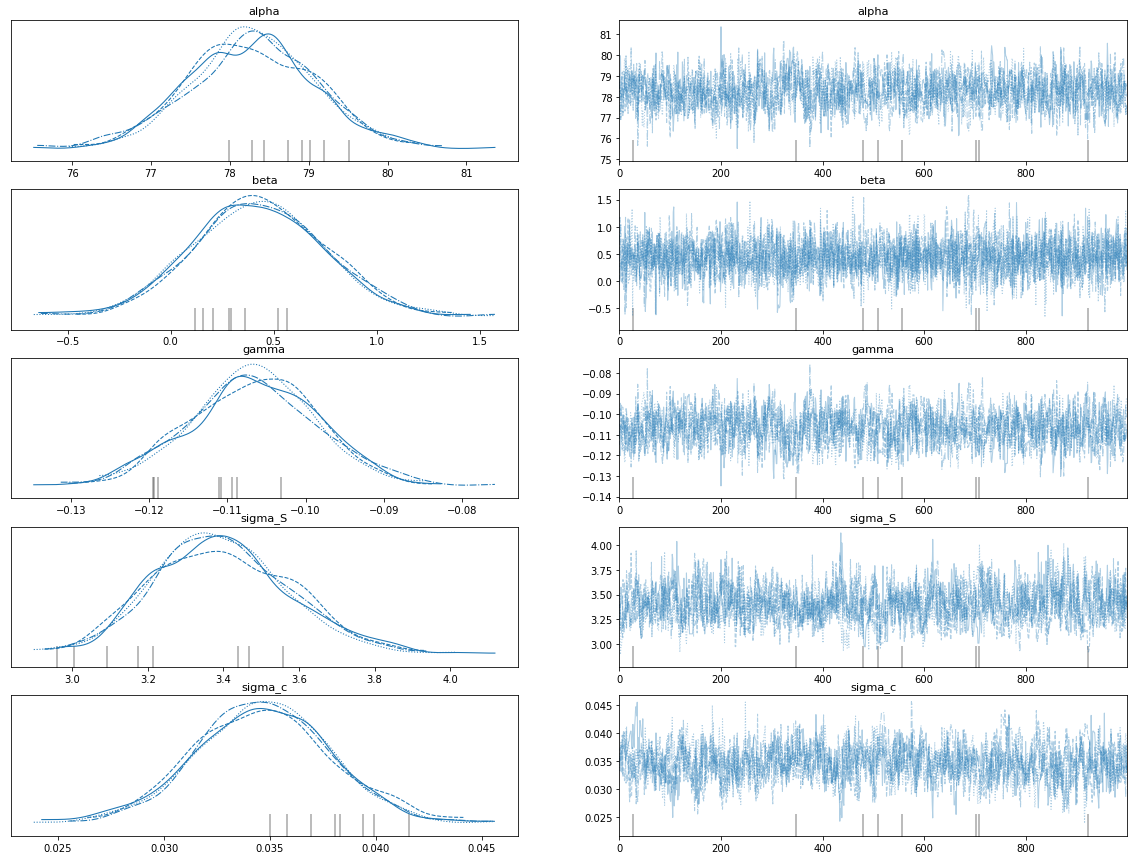

In [197]:
az.plot_trace(model4_trace, figsize=(20,15), var_names=['alpha', 'beta', 'gamma', 'sigma_S', 'sigma_c'])

## Let's use both random effects and add additional impact of treatment to liftrate coefficient impact

In [202]:
coords = {
    "worker": melted_full_obs['idx'].unique(),
    "obs_id": np.arange(melted_full_obs.shape[0])
}

with pm.Model(coords = coords) as model5:
    
    #register the data
    scores = pm.Data("scores", melted_full_obs['Average Safety Score'].values, mutable=True)    
    rates = pm.Data("lift_rates", melted_full_obs['Average Lift Rate'].values, mutable=True)    
    treatments = pm.Data("treatment", melted_full_obs['Treatment'].values, mutable=True) 
    idx = pm.Data("indx", melted_full_obs['idx'].values, mutable=True)
    
    ##Setting intercepts
    sigma_a = pm.HalfCauchy("sigma_a", 3)
    f_a = pm.Normal("fixed_a", 0, 1, dims="worker")
    α = pm.Normal("alpha", 0, 1000)
    a = pm.Deterministic("a", α + f_a[idx] * sigma_a, dims="obs_id")
       
    #Direct Treatment effect        
    b = pm.Normal("beta", 0, 1000)    
    
    
    
    ##Lift rate direct effect
    γ = pm.Normal("gamma", 0, 100)
    sigma_c = pm.HalfCauchy("sigma_c", 3)
    f_c = pm.Normal("fixed_c", 0, 1, dims="worker")        
    dir_c = pm.Deterministic("dir_c", γ + f_c[idx] * sigma_c, dims="obs_id")
    
    ##Add treatment influence
    z = pm.Normal("z", 0, 100)
    c = pm.Deterministic("c", dir_c + z * treatments, dims="obs_id")    
    
    ## Model errors
    sigma_S = pm.HalfCauchy("sigma_S", 3)    
    mu = pm.Deterministic("mu", a + b * treatments + c * rates, dims="obs_id")
    pm.Normal("s", mu, sigma_S, observed=scores, dims="obs_id")

In [203]:
with model5:
    model5_trace = pm.sample(tune=2_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/aurimas/apps/anaconda3/envs/strongarm/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, fixed_a, alpha, beta, gamma, sigma_c, fixed_c, z, sigma_S]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 45 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [204]:
az.summary(model5_trace, hdi_prob=0.90, var_names=['alpha', 'beta', 'gamma', 'sigma_S', 'sigma_c', "z", "sigma_a"])

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
alpha    78.631  1.030  76.970   80.352      0.031    0.022    1126.0   
beta      0.491  1.038  -1.183    2.176      0.027    0.019    1482.0   
gamma    -0.110  0.010  -0.126   -0.094      0.000    0.000    1079.0   
sigma_S   2.655  0.134   2.420    2.857      0.004    0.003    1222.0   
sigma_c   0.006  0.005   0.000    0.012      0.000    0.000     204.0   
z        -0.001  0.010  -0.018    0.015      0.000    0.000    1612.0   
sigma_a   3.936  0.246   3.543    4.316      0.010    0.007     705.0   

         ess_tail  r_hat  
alpha      1578.0   1.00  
beta       1878.0   1.00  
gamma      1499.0   1.01  
sigma_S    2021.0   1.00  
sigma_c     177.0   1.02  
z          1954.0   1.00  
sigma_a     727.0   1.00

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'gamma'}>,
        <AxesSubplot:title={'center':'gamma'}>],
       [<AxesSubplot:title={'center':'sigma_S'}>,
        <AxesSubplot:title={'center':'sigma_S'}>],
       [<AxesSubplot:title={'center':'sigma_c'}>,
        <AxesSubplot:title={'center':'sigma_c'}>],
       [<AxesSubplot:title={'center':'z'}>,
        <AxesSubplot:title={'center':'z'}>],
       [<AxesSubplot:title={'center':'sigma_a'}>,
        <AxesSubplot:title={'center':'sigma_a'}>]], dtype=object)

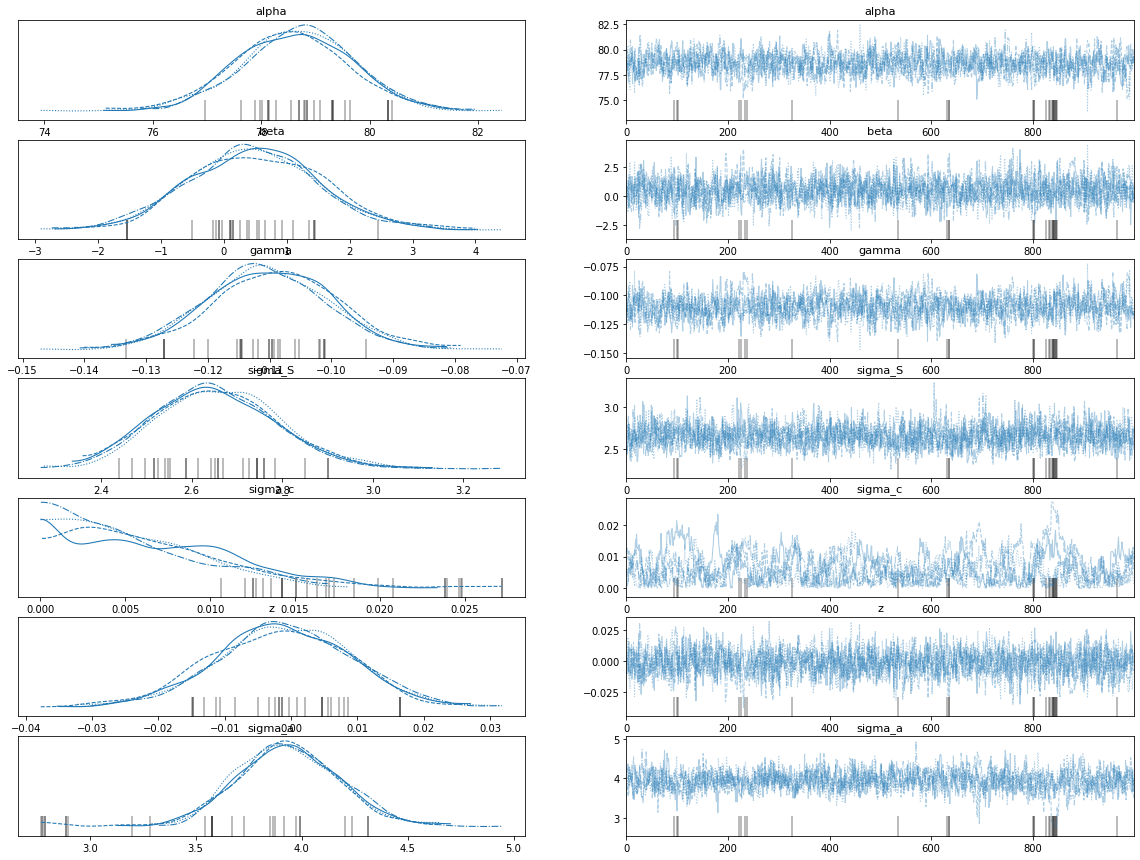

In [205]:
az.plot_trace(model5_trace, figsize=(20,15), var_names=['alpha', 'beta', 'gamma', 'sigma_S', 'sigma_c', "z", "sigma_a"])

## Final attempt - what about no direct impact?

In [206]:
coords = {
    "worker": melted_full_obs['idx'].unique(),
    "obs_id": np.arange(melted_full_obs.shape[0])
}

with pm.Model(coords = coords) as model6:
    
    #register the data
    scores = pm.Data("scores", melted_full_obs['Average Safety Score'].values, mutable=True)    
    rates = pm.Data("lift_rates", melted_full_obs['Average Lift Rate'].values, mutable=True)    
    treatments = pm.Data("treatment", melted_full_obs['Treatment'].values, mutable=True) 
    idx = pm.Data("indx", melted_full_obs['idx'].values, mutable=True)
    
    ##Setting intercepts
    sigma_a = pm.HalfCauchy("sigma_a", 3)
    f_a = pm.Normal("fixed_a", 0, 1, dims="worker")
    α = pm.Normal("alpha", 0, 1000)
    a = pm.Deterministic("a", α + f_a[idx] * sigma_a, dims="obs_id")
       
    #Direct Treatment effect        
    #b = pm.Normal("beta", 0, 1000)      
    
    ##Lift rate direct effect
    γ = pm.Normal("gamma", 0, 100)
    sigma_c = pm.HalfCauchy("sigma_c", 3)
    f_c = pm.Normal("fixed_c", 0, 1, dims="worker")        
    dir_c = pm.Deterministic("dir_c", γ + f_c[idx] * sigma_c, dims="obs_id")
    
    ##Add treatment influence
    z = pm.Normal("z", 0, 100)
    c = pm.Deterministic("c", dir_c + z * treatments, dims="obs_id")    
    
    ## Model errors
    sigma_S = pm.HalfCauchy("sigma_S", 3)    
    mu = pm.Deterministic("mu", a + c * rates, dims="obs_id")
    pm.Normal("s", mu, sigma_S, observed=scores, dims="obs_id")

In [207]:
with model6:
    model6_trace = pm.sample(tune=2_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/aurimas/apps/anaconda3/envs/strongarm/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, fixed_a, alpha, gamma, sigma_c, fixed_c, z, sigma_S]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 39 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [208]:
az.summary(model6_trace, hdi_prob=0.90, var_names=['alpha', 'gamma', 'sigma_S', 'sigma_c', "z", "sigma_a"])

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
alpha    78.942  0.850  77.542   80.334      0.027    0.019    1023.0   
gamma    -0.113  0.008  -0.126   -0.100      0.000    0.000    1063.0   
sigma_S   2.652  0.131   2.423    2.853      0.003    0.002    1538.0   
sigma_c   0.005  0.004   0.000    0.010      0.000    0.000     242.0   
z         0.004  0.003  -0.000    0.008      0.000    0.000    3345.0   
sigma_a   3.970  0.233   3.560    4.330      0.007    0.005    1134.0   

         ess_tail  r_hat  
alpha      2112.0   1.00  
gamma      1966.0   1.01  
sigma_S    2528.0   1.00  
sigma_c     179.0   1.01  
z          2611.0   1.00  
sigma_a    1802.0   1.01

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'gamma'}>,
        <AxesSubplot:title={'center':'gamma'}>],
       [<AxesSubplot:title={'center':'sigma_S'}>,
        <AxesSubplot:title={'center':'sigma_S'}>],
       [<AxesSubplot:title={'center':'sigma_c'}>,
        <AxesSubplot:title={'center':'sigma_c'}>],
       [<AxesSubplot:title={'center':'z'}>,
        <AxesSubplot:title={'center':'z'}>],
       [<AxesSubplot:title={'center':'sigma_a'}>,
        <AxesSubplot:title={'center':'sigma_a'}>]], dtype=object)

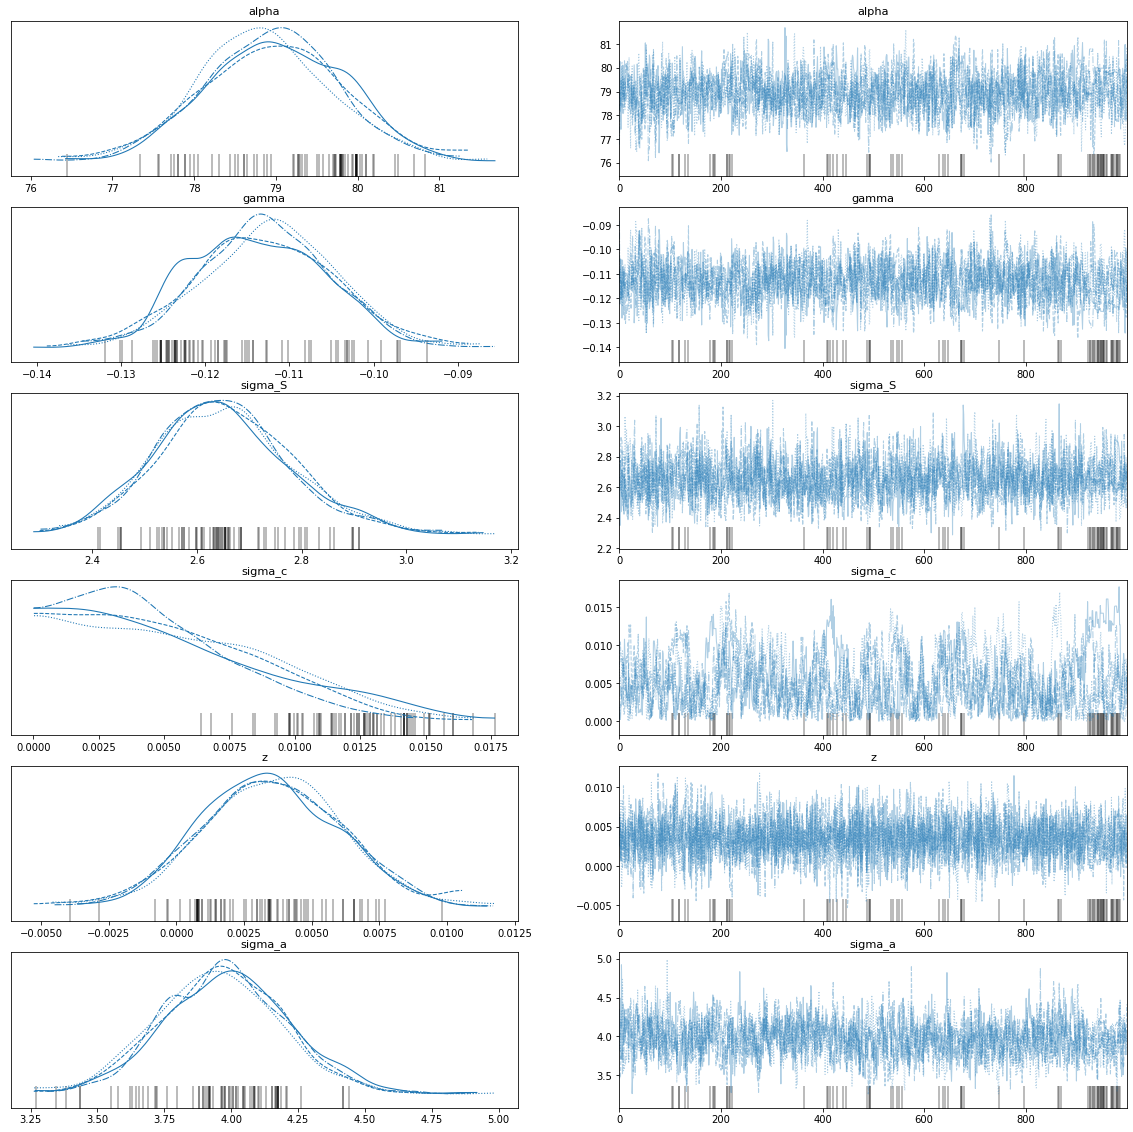

In [211]:
az.plot_trace(model6_trace, figsize=(20,20), var_names=['alpha', 'gamma', 'sigma_S', 'sigma_c', "z", "sigma_a"])

In [201]:
with pm.Model() as base_model:
    
    #register the data
    scores = pm.Data("scores", melted_full_obs['Average Safety Score'].values.reshape(-1, 1), mutable=True)    
    rates = pm.Data("lift_rates", melted_full_obs['Average Lift Rate'].values.reshape(-1, 1), mutable=True)    
    treatments = pm.Data("treatment", melted_full_obs['Treatment'].values.reshape(-1, 1), mutable=True) 
    
    idx_dummies = pd.get_dummies(melted_full_obs['ID']).values
    individuals = pm.Data("inds", idx_dummies, mutable=True)
    
    ##Setting intercepts
    sigma_a = pm.HalfCauchy("sigma_a", 3)
    f_a = pm.Normal("fixed_a", 0, 1, shape=(idx_dummies.shape[1], 1))
    α = pm.Normal("alpha", 0, 1000)
    ind_effs_a = pm.math.dot(individuals, f_a)
    
    a = pm.Deterministic("a", α + ind_effs_a * sigma_a)
    
    ## Setting up treatment effect
    sigma_b = pm.HalfCauchy("sigma_b", 3)    
    f_b = pm.Normal("fixed_b", 0, 1, shape=(idx_dummies.shape[1], 1))
    q = pm.Normal("q", 0, 100)
    β = pm.Normal("beta", 0, 100)
    ind_effs_b = pm.math.dot(individuals, f_b)
    b = pm.Deterministic("b", β + ind_effs_b * sigma_b + q * rates)
    
    ##Lift rate direct effect
    c = pm.Normal("c", 0, 100)
    
    ## Model errors
    sigma_S = pm.HalfCauchy("sigma_S", 3)    
    mu = a + b * treatments + c * rates
    pm.Normal("s", mu, sigma_S, observed=scores)

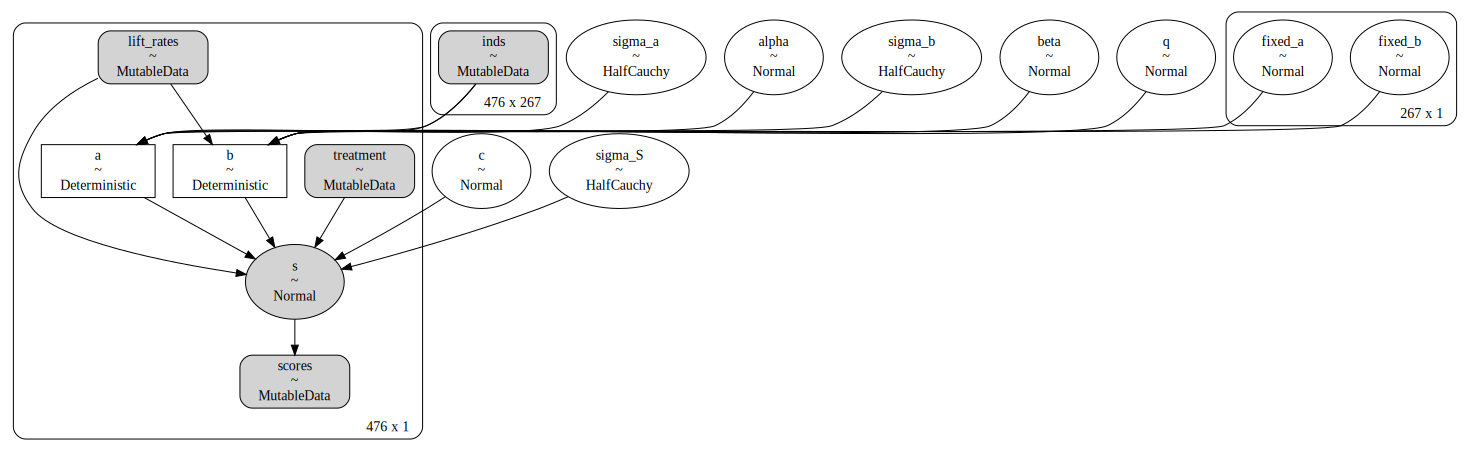

In [97]:
pm.model_to_graphviz(base_model)

In [98]:
with base_model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/aurimas/apps/anaconda3/envs/strongarm/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, fixed_a, alpha, sigma_b, fixed_b, q, beta, c, sigma_S]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1004 seconds.
There were 120 divergences after tuning. Increase `target_accept` or reparameterize.
There were 177 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 200 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7212, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<AxesSubplot:title={'center':'sigma_a'}>,
        <AxesSubplot:title={'center':'sigma_a'}>],
       [<AxesSubplot:title={'center':'sigma_b'}>,
        <AxesSubplot:title={'center':'sigma_b'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'sigma_S'}>,
        <AxesSubplot:title={'center':'sigma_S'}>]], dtype=object)

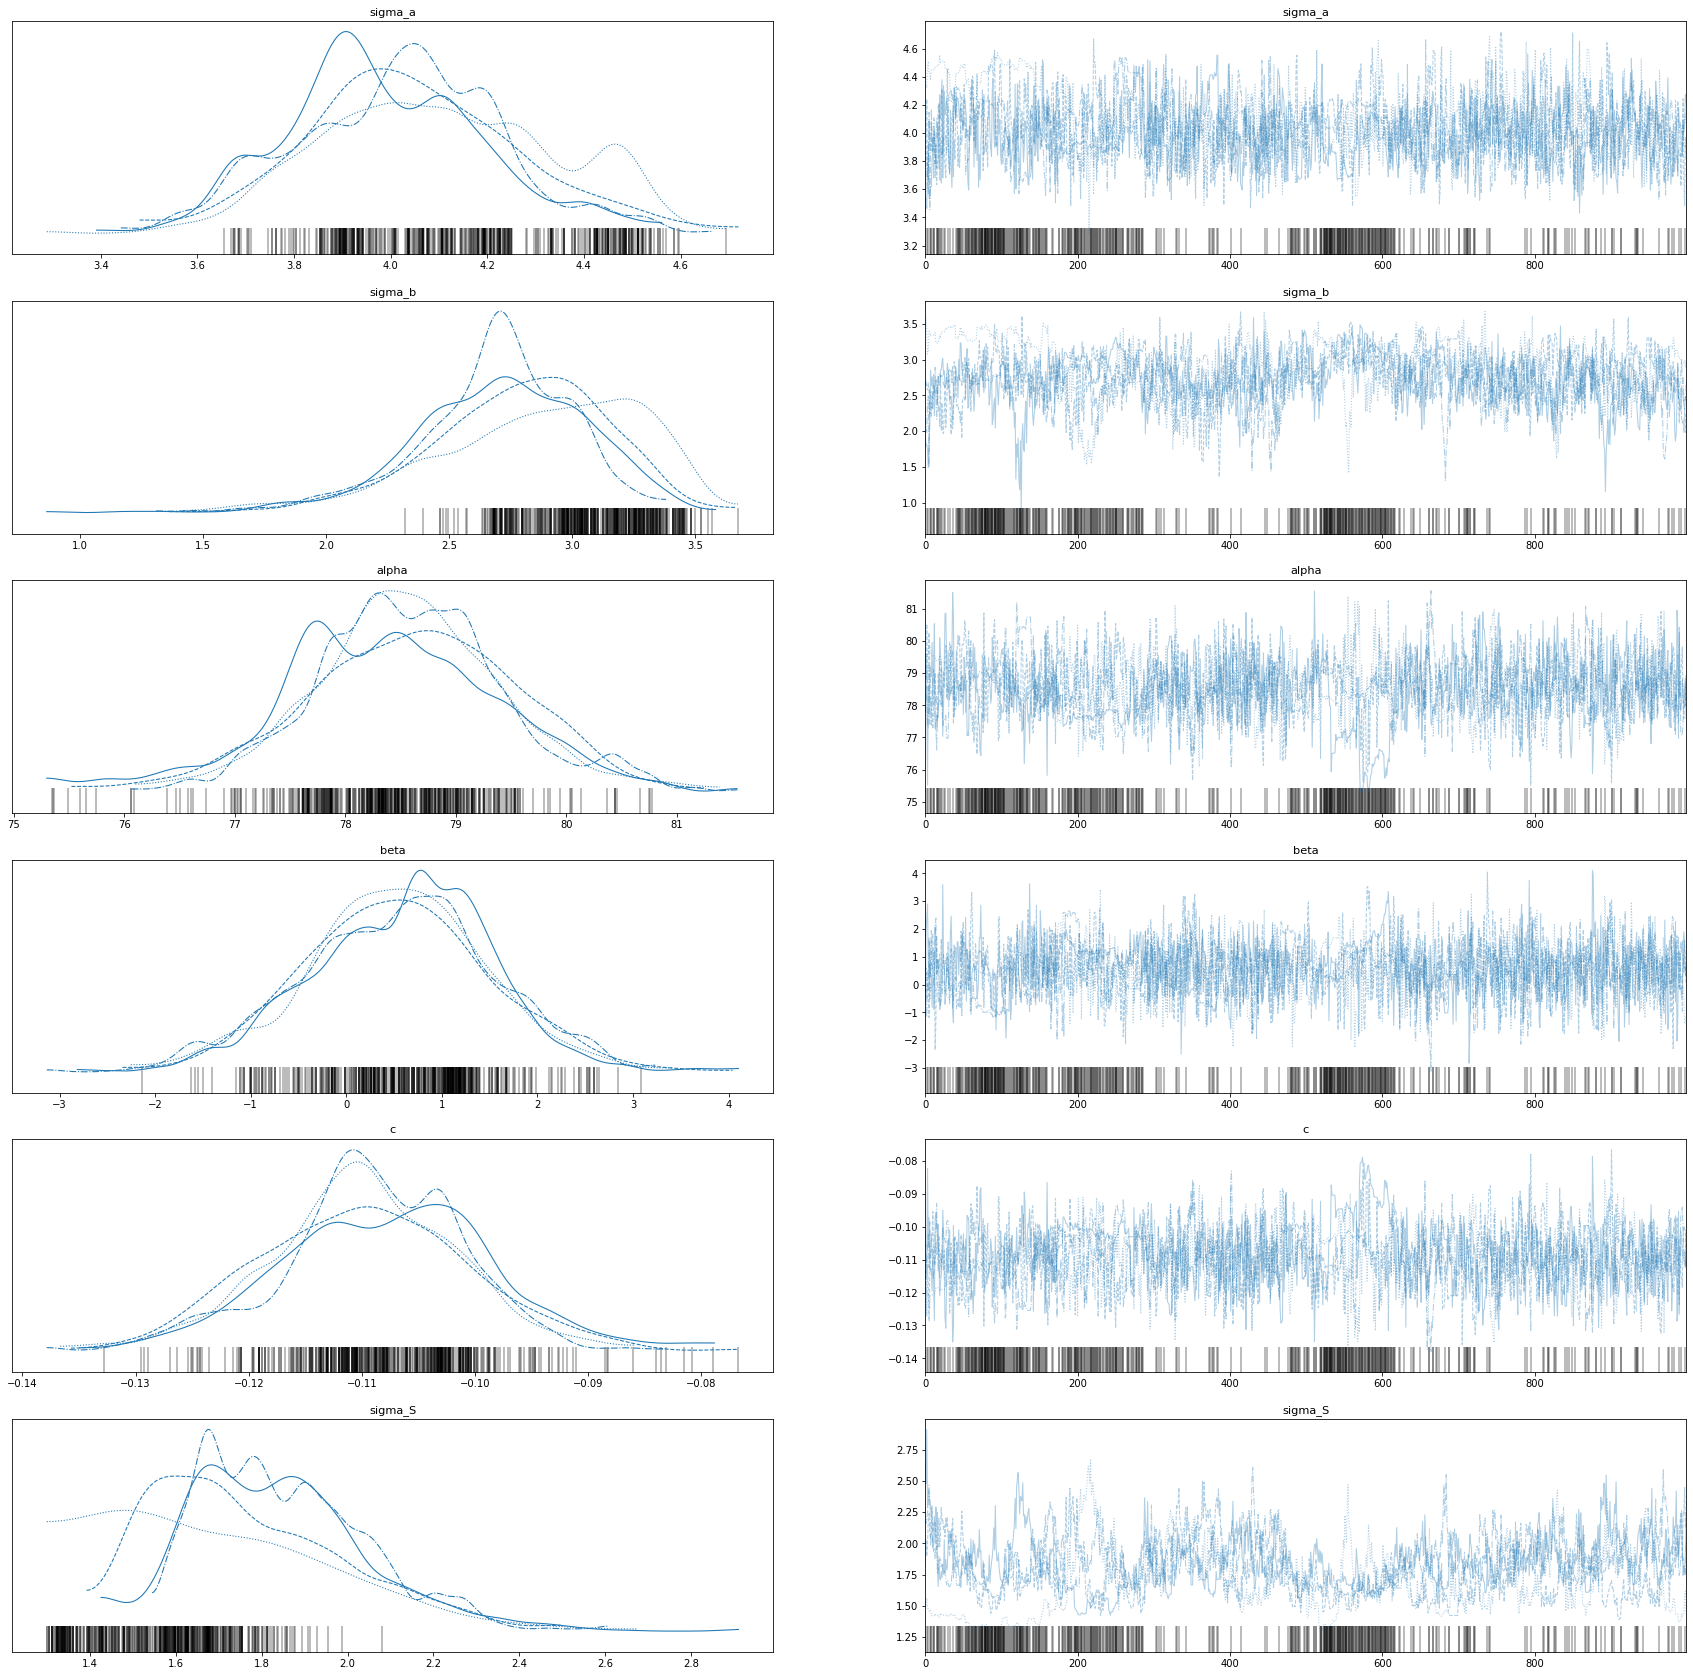

In [99]:
az.plot_trace(trace, figsize=(30,30), var_names=['sigma_a', 'sigma_b', 'alpha', 'beta', 'c', 'sigma_S'])

In [100]:
#vrs_int = ['lift_alpha', 'lift_treatment', 'score_treatment', 'lift_error', 'score_error', 'treatment_0_best', 'treatment_1_best', 'treatment_2_best', 'score_lift']
results = az.summary(trace, hdi_prob=0.90, var_names=['sigma_a', 'sigma_b', 'alpha', 'beta', 'c', 'sigma_S'])
results

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
sigma_a   4.037  0.224   3.671    4.429      0.023    0.017     110.0   
sigma_b   2.762  0.370   2.209    3.374      0.037    0.028      85.0   
alpha    78.538  0.935  76.975   80.018      0.054    0.038     313.0   
beta      0.548  0.964  -1.207    1.986      0.038    0.027     648.0   
c        -0.109  0.009  -0.125   -0.095      0.000    0.000     333.0   
sigma_S   1.790  0.233   1.411    2.168      0.029    0.021      49.0   

         ess_tail  r_hat  
sigma_a      78.0   1.03  
sigma_b      64.0   1.04  
alpha       276.0   1.01  
beta        987.0   1.01  
c           221.0   1.01  
sigma_S      24.0   1.07

array([[<AxesSubplot:title={'center':'lift_alpha'}>,
        <AxesSubplot:title={'center':'lift_alpha'}>],
       [<AxesSubplot:title={'center':'lift_treatment'}>,
        <AxesSubplot:title={'center':'lift_treatment'}>],
       [<AxesSubplot:title={'center':'score_treatment'}>,
        <AxesSubplot:title={'center':'score_treatment'}>],
       [<AxesSubplot:title={'center':'lift_error'}>,
        <AxesSubplot:title={'center':'lift_error'}>],
       [<AxesSubplot:title={'center':'score_error'}>,
        <AxesSubplot:title={'center':'score_error'}>],
       [<AxesSubplot:title={'center':'score_lift'}>,
        <AxesSubplot:title={'center':'score_lift'}>]], dtype=object)

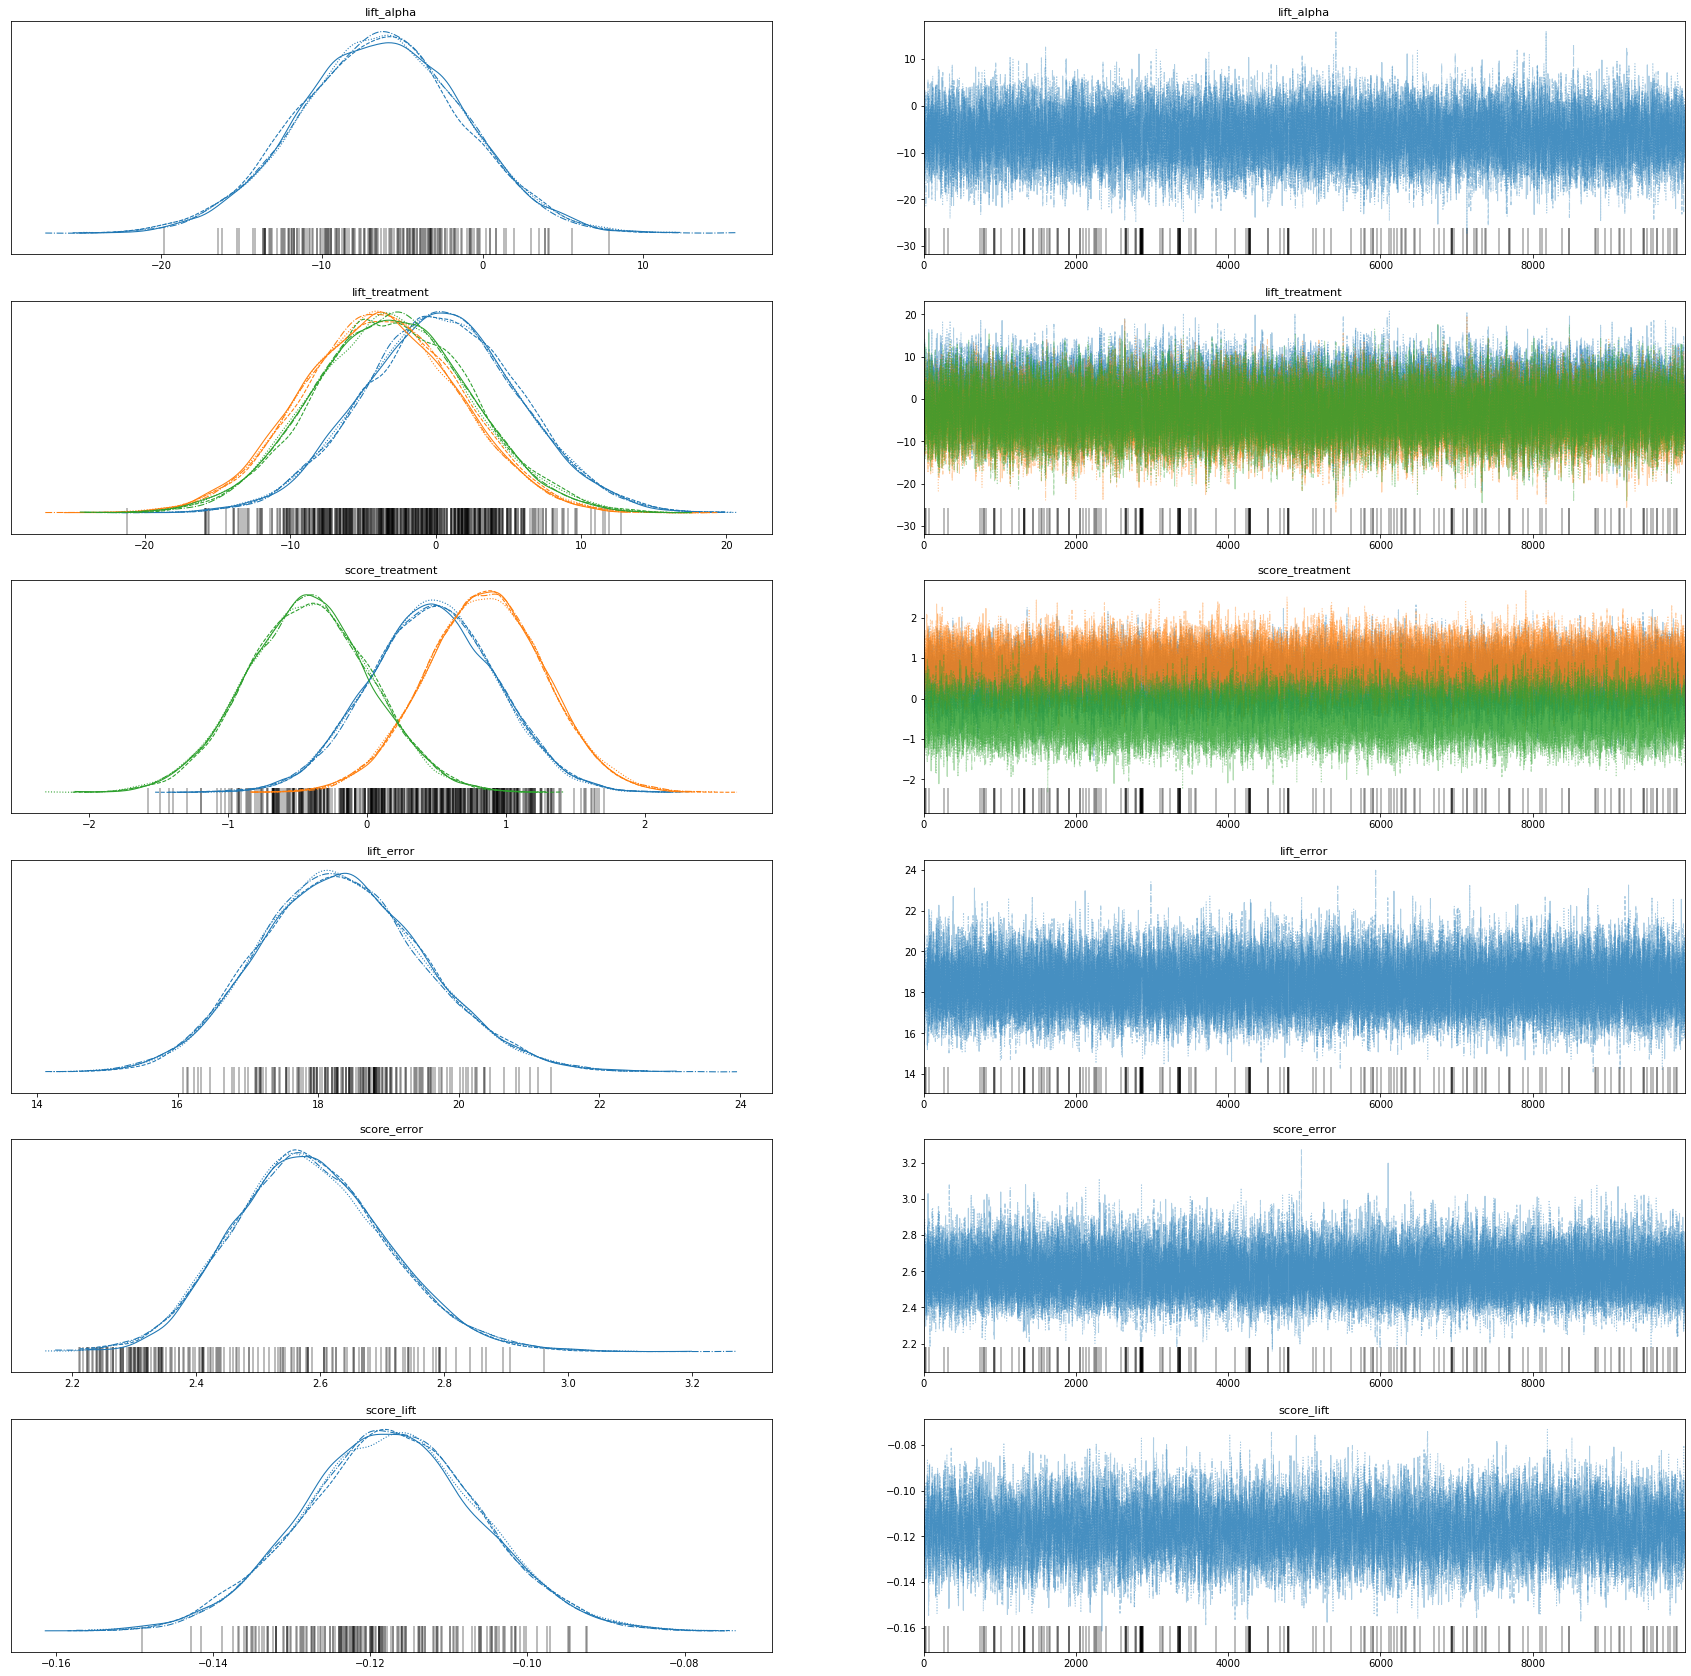

In [9]:
az.plot_trace(trace, figsize=(30,30), var_names=['lift_alpha', 'lift_treatment', 'score_treatment', 'lift_error', 'score_error', 'score_lift'])